In [1]:
import pandas as pd
import numpy as np
import tinkoffpy as tf
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from datetime import datetime, timedelta, date
import datetime

%matplotlib inline

now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

tf.auth_by_credentials(username='r.yunisov', password='Htyfn2002Htyfn')



/Users/r.yunisov/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Предтестовая аналитика

In [2]:
# df = tf.gp_to_df("""
# WITH cte AS (SELECT integration_id,
#                     crm_income_dt,
#                     DATE_TRUNC('month', crm_income_dt)::DATE AS crm_income_dt_month,
#                     DATE_TRUNC('week', crm_income_dt)::DATE  AS crm_income_dt_week,
#                     decision_dt,
#                     utilization_dt,
# --                     CASE
# --                         WHEN decision_dt - crm_income_dt <= 31 AND utilization_dt - crm_income_dt <= 31
# --                             THEN 'within 31 days'
# --                         ELSE 'over 31 day'
# --                         END                                     status,
#                     CASE
#                         WHEN decision_dt IS NULL THEN 0
#                         WHEN decision_dt IS NOT NULL AND application_status_cd = 'UTV' AND
#                              decision_dt - crm_income_dt <= 31 THEN 1
#                         ELSE 0
#                         END                                     status_open_rko,
#                     CASE
#                         WHEN utilization_dt IS NULL THEN 0
#                         WHEN utilization_dt IS NOT NULL AND utilization_dt - crm_income_dt <= 31 THEN 1
#                         ELSE 0
#                         END                                     status_util_rko
#              FROM prod_v_smemart.sme_application_scs
#              WHERE crm_income_dt > '2023-01-01')
# SELECT crm_income_dt,
#        integration_id,
#        utilization_dt - crm_income_dt AS diff_day
# --        crm_income_dt_month,
# --        SUM(status_open_rko)                                                           AS rko_open,
# --        SUM(status_util_rko)                                                           AS rko_util,
# --        COUNT(integration_id)                                                          AS total_qty,
# --        ROUND(SUM(status_open_rko)::NUMERIC / COUNT(integration_id)::NUMERIC * 100, 2) AS cr_to_open,
# --        ROUND(SUM(status_util_rko)::NUMERIC / COUNT(integration_id)::NUMERIC * 100, 2) AS cr_to_util_from_total,
# --        ROUND(SUM(status_util_rko)::NUMERIC / SUM(status_open_rko)::NUMERIC * 100, 2)  AS cr_to_util_from_open
# FROM cte
# -- GROUP BY crm_income_dt_month
# """, gp_service='sme')

In [3]:
# perc_70 = np.percentile(df.diff_day.dropna(), 70)

# plt.figure(figsize=(12,6))
# sns.distplot(df.diff_day.dropna())
# plt.vlines(perc_70, ymax=0.05, ymin=0, linestyles='dashed', label=f'70-й перцентиль - {perc_70} дней')
# plt.title('Distribution of date diff')
# plt.ylabel('Freq')
# plt.xlabel('Days')
# plt.legend()
# plt.show()

In [4]:
# df_1 = tf.gp_to_df("""
# SELECT *,
#        utilization_dt - crm_income_dt AS diff_day    
# FROM usr_wrk.ryunisov_nc_test_by_segments_0_1_d
# """,
#     gp_service='sme')

In [5]:
# perc_90_2 = np.percentile(df_1.diff_day.dropna(), 90)

# plt.figure(figsize=(12,6))
# sns.distplot(df_1.diff_day.dropna())
# plt.vlines(perc_90_2, ymax=0.05, ymin=0, linestyles='dashed', colors='green', label=f'90-й перцентиль - {perc_90_2} дней c 2023-05')
# plt.vlines(30, ymax=0.05, ymin=0, linestyles='dashed', colors='black', label=f'90-й перцентиль - {30.0} дней c 2023-06')
# plt.title('Distribution of date diff')
# plt.ylabel('Freq')
# plt.xlabel('Days')
# plt.legend()
# plt.show()

## Собираем данные и отчет для отправки в time

In [6]:
df = tf.gp_to_df("""
SELECT *
FROM usr_wrk.ryunisov_novoregi_test_report
""", gp_service='sme')

df1=df.groupby(['crm_income_dt', 'groups'], as_index=False)['party_rk', 'open_rko_dt', 'utilization_dt'].agg('count')

df1['cr_to_rko'] = df1['open_rko_dt'] / df1['party_rk'] * 100

df1['cr_to_util'] = df1['utilization_dt'] / df1['party_rk'] * 100


df2=df.groupby('groups', as_index=False)['party_rk', 'open_rko_dt', 'utilization_dt'].agg('count')

df2['cr_to_rko'] = df2['open_rko_dt'] / df2['party_rk'] * 100

df2['cr_to_util'] = df2['utilization_dt'] / df2['party_rk'] * 100


for_chart = df1.replace({'test_partners_0_day_push':'Тест', 
                         'test_partners_0_day_control':'Контроль'})

for_chart.rename(columns={
                          'party_rk':'Заявки', 
                          'open_rko_dt':'Открытых РКО', 
                          'utilization_dt':'Утилизации', 
                          'cr_to_rko':'%, Доля открытых РКО',
                          'cr_to_util':'%, Доля утилизаций',
                          'crm_income_dt':'Дата заявки',
                          'groups':'Группы'
                          },
                          inplace=True)

for_table = df2.replace({'test_partners_0_day_push':'Тест', 
                         'test_partners_0_day_control':'Контроль'})

for_table.rename(columns={
                          'party_rk':'Заявки', 
                          'open_rko_dt':'Открытых РКО', 
                          'utilization_dt':'Утилизации', 
                          'cr_to_rko':'%, Доля открытых РКО',
                          'cr_to_util':'%, Доля утилизаций',
                          'groups':'Группы'
                          },
                          inplace=True)

for_table = for_table.round(2)

for_chart = for_chart.round(2)

fig_table = ff.create_table(for_table)

for i in range(len(fig_table.layout.annotations)):
    fig_table.layout.annotations[i].font.size = 20

fig_table.show()

# fig_table.write_image("final_table.png", width=2000, height=700)

fig_line = px.line(for_chart, x='Дата заявки', y='%, Доля утилизаций', color='Группы', text='%, Доля утилизаций')

fig_line.show()

# fig_line.write_image("curve_of_cr.png", width=2000, height=1000)

fig_line_2 = px.line(for_chart, x='Дата заявки', y='Заявки', color='Группы', text='Заявки')

fig_line_2.show()

# fig_line_2.write_image("curve_of_cr_2.png", width=2000, height=1000)

attach = ['final_table.png', 'curve_of_cr.png', 'curve_of_cr_2.png']

now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

text = f'Отчет по новому тесту коммуникаций на 0,1 и 7 дни по новорегам @e.podolyako :alarmalarm: \n\nДанные актуальны на: **{now}**'

recipients = ['communication_test_reporting']

# recipients2 = ['iva.antonov']

# tf.send_to_time(recipients2, text, attach)

2023-12-05 10:58:38 - WARNING - Library version is outdated, you have: 1.0.49
actual version: 1.0.53, please, update library.
2023-12-05 10:59:14 - INFO - Query executed successfully. Result saved to DataFrame.


/var/folders/3g/twm5z59x18s28jmjj3c3ghfm0000gq/T/ipykernel_42894/3454054909.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df1=df.groupby(['crm_income_dt', 'groups'], as_index=False)['party_rk', 'open_rko_dt', 'utilization_dt'].agg('count')
/var/folders/3g/twm5z59x18s28jmjj3c3ghfm0000gq/T/ipykernel_42894/3454054909.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2=df.groupby('groups', as_index=False)['party_rk', 'open_rko_dt', 'utilization_dt'].agg('count')


## Строим винтажи по утилизациям

In [7]:
# df_vin = tf.gp_to_df("""
# SELECT *, ROUND((cum_sum::NUMERIC / total_int::NUMERIC) * 100, 2) AS prop
# FROM (SELECT *,
#              SUM(open_rko_dt)
#              OVER (PARTITION BY groups ORDER BY date_util_diff ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cum_sum,
#              SUM(total_clients) OVER (PARTITION BY groups)                                                       AS total_int
#       FROM (SELECT groups,
#                    --crm_income_dt,
#                    (open_rko_dt - crm_income_dt) AS date_util_diff,
#                    COUNT(party_rk)                  AS total_clients,
#                    COUNT(open_rko_dt)            AS open_rko_dt
#             FROM usr_wrk.ryunisov_novoregi_test_report
#                      WHERE crm_income_dt BETWEEN '2023-09-07' AND current_date - 30
#             GROUP BY groups,
#                      --crm_income_dt,
#                      (open_rko_dt - crm_income_dt)) tt) ttt
# """, gp_service='sme')

df_vin = tf.gp_to_df("""
SELECT *, ROUND((cum_sum::NUMERIC / total_int::NUMERIC) * 100, 2) AS prop
FROM (SELECT *,
             SUM(utilizations)
             OVER (PARTITION BY groups ORDER BY date_util_diff ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cum_sum,
             SUM(total_clients) OVER (PARTITION BY groups)                                                       AS total_int
      FROM (SELECT groups,
                   --crm_income_dt,
                   (utilization_dt - crm_income_dt) AS date_util_diff,
                   COUNT(party_rk)                  AS total_clients,
                   COUNT(utilization_dt)            AS utilizations
            FROM usr_wrk.ryunisov_novoregi_test_report
            WHERE crm_income_dt BETWEEN '2023-09-07' AND current_date - 30
            GROUP BY groups,
                     --crm_income_dt,
                     (utilization_dt - crm_income_dt)) tt) ttt 
""", gp_service='sme')

df_vin = df_vin.replace({'test_partners_0_day_push':'Тест', 
                         'test_partners_0_day_control':'Контроль'})

for_chart = df_vin.groupby(['groups', 'date_util_diff'], as_index=False)['prop'].agg('mean')

# for_chart['segment'] = for_chart['groups'] + ', ' + for_chart['crm_income_dt']

fig = px.line(for_chart.round(2), x='date_util_diff', y='prop', color='groups', markers=True, text='prop', width=1800, 
               height=1100)
fig = fig.update_traces(textposition="bottom right")
fig.show()

2023-12-05 11:00:01 - INFO - Query executed successfully. Result saved to DataFrame.


## Смотрим конверсию из открытия в утиль

In [8]:
df_test = tf.gp_to_df("""
SELECT *, ROUND((cum_sum::NUMERIC / total_int::NUMERIC) * 100, 2) AS prop
FROM (SELECT *,
             SUM(utilizations)
             OVER (PARTITION BY groups ORDER BY date_util_diff ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cum_sum,
             SUM(total_rko_clients) OVER (PARTITION BY groups)                                                   AS total_int
      FROM (SELECT groups,
                   --crm_income_dt,
                   (utilization_dt - crm_income_dt) AS date_util_diff,
                   COUNT(open_rko_dt)               AS total_rko_clients,
                   COUNT(utilization_dt)            AS utilizations
            FROM usr_wrk.ryunisov_novoregi_test_report
            WHERE crm_income_dt BETWEEN '2023-09-07' AND CURRENT_DATE - 30
            GROUP BY groups,
                     --crm_income_dt,
                     (utilization_dt - crm_income_dt)) tt) ttt
""", gp_service = 'sme')

for_chart_test = df_test.groupby(['groups', 'date_util_diff'], as_index=False)['prop'].agg('mean')

fig = px.line(for_chart_test.round(2), x='date_util_diff', y='prop', color='groups', markers=True, text='prop', width=1800, 
               height=1100)
fig = fig.update_traces(textposition="bottom right")
fig.show()

2023-12-05 11:00:53 - INFO - Query executed successfully. Result saved to DataFrame.


## Аппроксимируем линию утилизаций

In [9]:
from scipy.optimize import curve_fit 
from numpy import array, exp 
import matplotlib.pyplot as plt 
import math

Arguments:  [ 5.77340234e+00  2.38045148e+01  3.67210590e-02 -3.70663577e+01]
Co-Variance:  [[ 6.67710997e-04 -2.79770178e+03 -1.12843988e-05  3.20055679e+03]
 [-2.79770178e+03  4.69379853e+13  2.16444186e+02 -5.36969861e+13]
 [-1.12843988e-05  2.16444186e+02  2.26523378e-07 -2.47611614e+02]
 [ 3.20055679e+03 -5.36969861e+13 -2.47611614e+02  6.14292730e+13]]


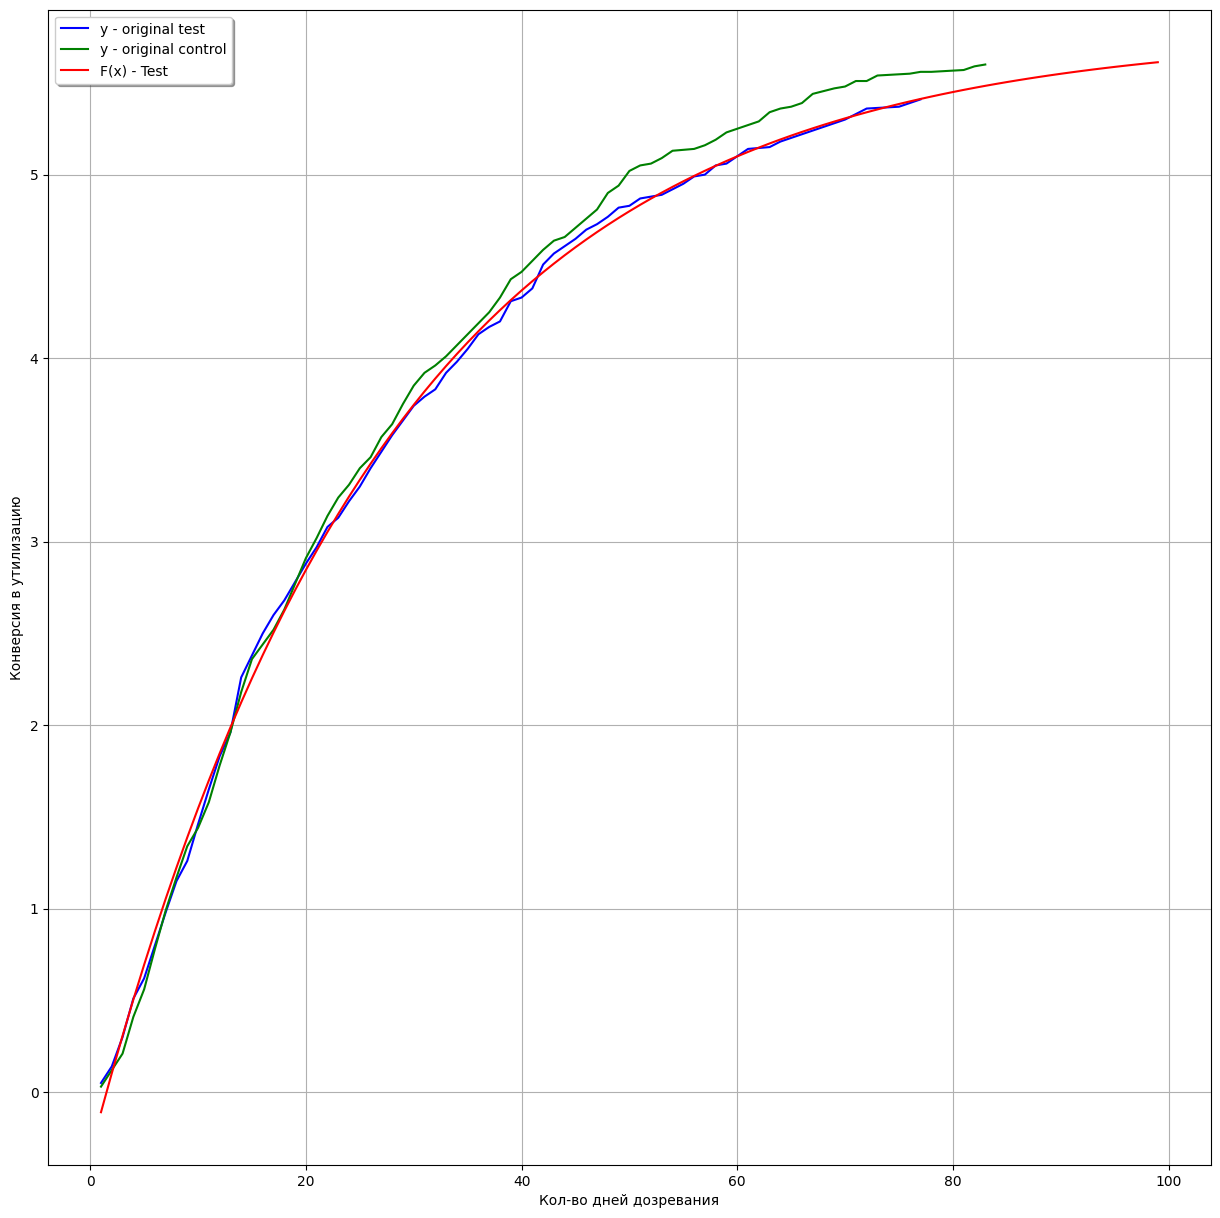

In [10]:
# a = np.exp(np.polyfit(x, np.log(y), 2))[1]
# b = np.polyfit(x, np.log(y), 1)[0]

y = for_chart.query("groups == 'Тест'")['prop']
x = for_chart.query("groups == 'Тест'")['date_util_diff']

y_con = for_chart.query("groups == 'Контроль'")['prop']
x_con = for_chart.query("groups == 'Контроль'")['date_util_diff']


# Test group

y = list(y)
x = list(x)

# Задаем данные для обучения
x_learn= x[:]
y_learn = y[:]

# Создаем функцию для аппроксимации
def mapping(x, a, b, c, d): 
    # return a * np.log(x) + b
    return a - b * np.exp(-c * (x - d))


# Используем метод для подбора агрументов (МНК)
args, _ = curve_fit(mapping, x_learn, y_learn, 
                    p0 = [3.6, 1.4, 1, 18.2]
                    ) 
print("Arguments: ", args) 
print("Co-Variance: ", _) 

a, b, c, d = args[0], args[1], args[2], args[3]


# Создаем кол-во дней для отрисовки предикт линии
x1 = []

for i in range(1, 100):
    x1.append(i)

# Создаем предсказанные данные на основании кол-ва дней используя подобранные аргументы и подобранную функцию
y1 = []

for i in x1:
    # y1.append(a * np.log(i) + b)
    # y1.append(2.275 - 1.36 * np.exp(-0.055 * (i - 7.2)))
    y1.append(a - b * np.exp(-c * (i - d)))


plt.figure(figsize=(15, 15))
plt.plot(x, y, label="y - original test", color='b')
plt.plot(x_con, y_con, label="y - original control", color='green') 
plt.plot(x1, y1, label="F(x) - Test", color ='r')
# plt.plot(x1_con, y1_con, label="F(x)- Control", color ='r') 
plt.xlabel('Кол-во дней дозревания') 
plt.ylabel('Конверсия в утилизацию') 
plt.legend(loc = 'best', fancybox = True, shadow = True) 
plt.grid(True)
plt.show()

## Создаем воронки по коммуникациям для отчета

In [11]:
# Пуши мейлы смс

df_com = tf.gp_to_df("""
SELECT t1.*,
       CASE
           WHEN template_code = 'sme_xsell_novoreg_rko_push' THEN '0 день пуш'
           WHEN template_code = 'sme_xsell_novoreg_rko_chat' THEN '0 день чат'
           WHEN template_code = 'sme_xsell_novoreg1_rko_push' THEN '1 день пуш'
           WHEN template_code = 'sme_xsell_novoreg1_rko_chat' THEN '1 день чат'
           WHEN template_code = 'sme_xsell_novoreg7_rko_push' THEN '7 день пуш'
           WHEN template_code = 'sme_xsell_novoreg7_rko_chat' THEN '7 день чат'
           WHEN template_code = 'BULK_AdHoc_Sme_Xsell_Nreg' THEN '0 день мейл'
           WHEN template_code = 'BULK_AdHoc_Sme_Xsell_Nreg_1d' THEN '1 день мейл'
           WHEN template_code = 'BULK_AdHoc_Sme_Xsell_Nreg_7d' THEN '7 день мейл'
           WHEN template_code = 'sme_xsell_novoreg_rko_sms' THEN '0 день смс'
           WHEN template_code = 'sme_xsell_novoreg1_rko_sms' THEN '1 день смс'
           WHEN template_code = 'sme_xsell_novoreg7_rko_sms' THEN '7 день смс'
           END groups,
       t2.party_rk
FROM prod_v_usermart.esb_notification t1
         JOIN prod_v_emart.person_party t2
               ON t1.party_id = t2.party_id
         JOIN usr_wrk.hist_table_xsell_14689 t3
               ON t2.party_rk = t3.customer_rk
WHERE template_code IN
      (
       'sme_xsell_novoreg_rko_push',
       'sme_xsell_novoreg_rko_chat',
       'sme_xsell_novoreg1_rko_push',
       'sme_xsell_novoreg1_rko_chat',
       'sme_xsell_novoreg7_rko_push',
       'sme_xsell_novoreg7_rko_chat',
       'BULK_AdHoc_Sme_Xsell_Nreg',
       'BULK_AdHoc_Sme_Xsell_Nreg_1d',
       'BULK_AdHoc_Sme_Xsell_Nreg_7d',
       'sme_xsell_novoreg_rko_sms',
       'sme_xsell_novoreg1_rko_sms',
       'sme_xsell_novoreg7_rko_sms'
          )
""", gp_service='sme')

df_com.head()

df_com.groupby('groups', as_index=False)['party_id'].agg('nunique')

2023-12-05 11:09:52 - INFO - Query executed successfully. Result saved to DataFrame.


,groups,party_id
0,0 день пуш,9157
1,0 день смс,2928
2,0 день чат,9157
3,1 день пуш,16217
4,1 день смс,9001
5,1 день чат,16299
6,7 день пуш,16238
7,7 день смс,8887
8,7 день чат,16324


In [12]:
# Сторисы

# 1) 0 день
# Story ID (iOS/Android): 28947
# Fullscreen ID (iOS/Android): 28948
# 2) 1 день
# Story ID (iOS/Android): 28949
# 3) 7 день
# Story ID (iOS/Android): 28950
# Fullscreen ID (iOS/Android): 28951*

df_story = tf.gp_to_df("""
SELECT t1.*,
       CASE
           WHEN story_id = 28947 THEN '0 день story'
           WHEN story_id = 28948 THEN '0 день fullscreen'
           WHEN story_id = 28949 THEN '1 день story'
           WHEN story_id = 28950 THEN '7 день story'
           WHEN story_id = 28951 THEN '7 день fullscreen'
           END segments,
       t2.party_rk as party_rk0
FROM prod_v_usermart.tinkoff_stories_statistics t1
         LEFT JOIN prod_v_dds.program_product_user t2
                   ON t1.program_product_user_id = t2.program_product_user_id
WHERE story_id IN (28947, 28948, 28949, 28950, 28951)
""", gp_service = 'sme')

df_story.head()

df_story.groupby('segments', as_index=False).agg({'program_product_user_rk':'nunique'})

2023-12-05 11:14:54 - INFO - Query executed successfully. Result saved to DataFrame.


,segments,program_product_user_rk
0,0 день fullscreen,1
1,1 день story,897
2,7 день fullscreen,7776
3,7 день story,1035


In [13]:
# Баннеры
# 0 день
#     'Главная': [117175],
#     'Лента операций': [117178],
#     'Новые Детали счета': [117179],
#     'Новые Бонусы': [117180],  
#     'Витрина после редизайна 2.0': [117181],
#     'inapp (Главная)': [117182]

# 1 день
#     'Главная': [117185],
#     'Лента операций': [117186],
#     'Новые Детали счета': [117187],
#     'Новые Бонусы': [117188],  
#     'Витрина после редизайна 2.0': [117189],
#     'inapp (Главная)': [117190]

# 7 день
#     'Главная': [117191],
#     'Лента операций': [117192],
#     'Новые Детали счета': [117193],
#     'Новые Бонусы': [117194],  
#     'Витрина после редизайна 2.0': [117195],
#     'inapp (Главная)': [117196]

df_bann = tf.gp_to_df("""
SELECT t1.*,
       CASE
           WHEN advt_strategy_id = 63226 THEN 'Главная 1 день'
           WHEN advt_strategy_id = 63233 THEN 'Главная 7 день'
           WHEN advt_strategy_id = 63227 THEN 'Лента операция 1 день'
           WHEN advt_strategy_id = 63234 THEN 'Лента операция 7 день'
           WHEN advt_strategy_id = 63228 THEN 'Детали счета 1 день'
           WHEN advt_strategy_id = 63235 THEN 'Детали счета 7 день'
           WHEN advt_strategy_id = 63229 THEN 'Новые бонусы 1 день'
           WHEN advt_strategy_id = 63236 THEN 'Новые бонусы 7 день'
           WHEN advt_strategy_id = 63230 THEN 'Экран новый продукт 1 день'
           WHEN advt_strategy_id = 63237 THEN 'Экран новый продукт 7 день'
           END banner_status,
       t2.party_rk
FROM usr_wrk.sme_banner_logs t1
         LEFT JOIN prod_v_dds.program_product_user t2
                   ON t1.program_product_user_id::VARCHAR = t2.program_product_user_id
WHERE advt_strategy_id IN (63226, 63233, 63227, 63234, 63228, 63235, 63229, 63236, 63230, 63237);
""", gp_service='sme')

df_bann.groupby('banner_status', as_index=False).agg({'program_product_user_id':'nunique'})

2023-12-05 11:15:25 - INFO - Query executed successfully. Result saved to DataFrame.


,banner_status,program_product_user_id
0,Главная 1 день,2306
1,Главная 7 день,2842
2,Детали счета 1 день,1087
3,Детали счета 7 день,1406
4,Лента операция 1 день,497
5,Лента операция 7 день,58
6,Новые бонусы 1 день,334
7,Новые бонусы 7 день,485
8,Экран новый продукт 1 день,131
9,Экран новый продукт 7 день,139


## Рисуем воронки по коммуникациям

In [14]:
df_funnel = tf.gp_to_df("""
SELECT tool,
       day,
       specific_status,
       SUM(number_of_clients) AS clients,
       CASE
           WHEN specific_status = 'delivered' THEN 5
           WHEN specific_status = 'sent' THEN 4
           WHEN specific_status = 'read' THEN 6
           WHEN specific_status = 'pixel' THEN 3
           WHEN specific_status = 'click' THEN 7
           WHEN specific_status = 'failed' THEN 1
           WHEN specific_status = 'applications' THEN 8
           WHEN specific_status = 'imp' THEN 2
           END                   ranking
FROM usr_wrk.ryunisov_funnel_by_communications
GROUP BY tool, day, specific_status
""", gp_service='sme')

df_funnel

2023-12-05 11:16:07 - INFO - Query executed successfully. Result saved to DataFrame.


,tool,day,specific_status,clients,ranking
0,stories,7,imp,16678.0,2
1,push,0,read,863.0,6
2,sms,7,sent,208.0,4
3,push,7,NaN,4.0,<NA>
4,stories,7,click,6759.0,7
5,sms,1,delivered,8959.0,5
6,sms,0,failed,27.0,1
7,push,1,failed,8381.0,1
8,push,1,sent,1578.0,4
9,chat,7,delivered,16530.0,5


In [15]:
df_funnel_sms = df_funnel.query("tool == 'sms'").sort_values('ranking', ascending=True)

df_funnel_push = df_funnel.query("tool == 'push'").sort_values('ranking', ascending=True)

df_funnel_stories = df_funnel.query("tool == 'stories'").sort_values('ranking', ascending=True)

df_funnel_chat = df_funnel.query("tool == 'chat'").sort_values('ranking', ascending=True)

In [16]:

df_funnel_sms['consolid'] = df_funnel_sms['tool'] + ', ' + df_funnel_sms['specific_status'] 

df_funnel_push['consolid'] = df_funnel_push['tool'] + ', ' + df_funnel_push['specific_status'] 

df_funnel_stories['consolid'] = df_funnel_stories['tool'] + ', ' + df_funnel_stories['specific_status'] 

df_funnel_chat['consolid'] = df_funnel_chat['tool'] + ', ' + df_funnel_chat['specific_status'] 


In [17]:
fig = px.funnel(
                df_funnel_sms, x='consolid', y='clients',
                color = 'day'
                )
fig.show()

In [18]:
fig = px.funnel(
                df_funnel_push, x='consolid', y='clients',
                color = 'day'
                )
fig.show()

In [19]:
fig = px.funnel(
                df_funnel_stories, x='consolid', y='clients',
                color = 'day'
                )
fig.show()

In [20]:
fig = px.funnel(
                df_funnel_chat, x='consolid', y='clients',
                color = 'day'
                )
fig.show()

# Подводим результаты по эксперименту. Сравниваем разные шаги и используем критерий Т-Стюдента

In [21]:
import scipy.stats as sps

In [22]:
df_cr = tf.gp_to_df("""
SELECT groups,
       crm_income_dt,
       COUNT(party_rk)                                                   AS clients,
       COUNT(open_rko_dt)                                                AS rko,
       COUNT(utilization_dt)                                             AS utilizations,
       (COUNT(utilization_dt)::NUMERIC / COUNT(party_rk)::NUMERIC) * 100 AS prop_of_util,
       (COUNT(open_rko_dt)::NUMERIC / COUNT(party_rk)::NUMERIC) * 100    AS prop_of_rko
FROM usr_wrk.ryunisov_novoregi_test_report t1
         JOIN (SELECT CASE
                          WHEN day_of_week_nm = 'Sunday' THEN 1
                          WHEN day_of_week_nm = 'Saturday' THEN 1
                          ELSE 0
                          END weekend_status_flg,
                      calendar_dt
               FROM prod_v_DDS.DDS_CALENDAR_DATE) t2
              ON t1.crm_income_dt = t2.calendar_dt
                  AND weekend_status_flg = 0
GROUP BY groups,
         crm_income_dt
""", gp_service='sme')

df_cr = df_cr.query("crm_income_dt <= '2023-10-21'")

2023-12-05 11:18:00 - INFO - Query executed successfully. Result saved to DataFrame.


In [23]:
df_test_rko = df_cr.query("groups == 'test_partners_0_day_push'")['prop_of_rko'].round(2)

df_control_rko = df_cr.query("groups == 'test_partners_0_day_control'")['prop_of_rko'].round(2)

df_test_util = df_cr.query("groups == 'test_partners_0_day_push'")['prop_of_util'].round(2)

df_control_util = df_cr.query("groups == 'test_partners_0_day_control'")['prop_of_util'].round(2)

df_control_util = list(df_control_util)

df_test_util = list(df_test_util)

df_control_rko = list(df_control_rko)

df_test_rko = list(df_test_rko)

In [24]:
df_cr.sort_values('crm_income_dt', ascending=False)

,groups,crm_income_dt,clients,rko,utilizations,prop_of_util,prop_of_rko
106,test_partners_0_day_control,2023-10-20,297,26,16,5.387205,8.754209
126,test_partners_0_day_push,2023-10-20,345,32,16,4.637681,9.275362
98,test_partners_0_day_push,2023-10-19,342,28,14,4.093567,8.187135
36,test_partners_0_day_control,2023-10-19,337,30,16,4.747774,8.902077
76,test_partners_0_day_push,2023-10-18,330,33,16,4.848485,10.0
...,...,...,...,...,...,...,...
127,test_partners_0_day_control,2023-08-28,397,31,16,4.030227,7.808564
30,test_partners_0_day_push,2023-08-25,325,17,9,2.769231,5.230769
53,test_partners_0_day_control,2023-08-25,323,20,10,3.095975,6.19195
94,test_partners_0_day_push,2023-08-24,335,19,14,4.179104,5.671642


In [25]:
for_chart = df_cr[['groups', 'prop_of_rko']]

test = for_chart.query("groups == 'test_partners_0_day_push'")['prop_of_rko']

control = for_chart.query("groups == 'test_partners_0_day_control'")['prop_of_rko']

test_mean = for_chart.query("groups == 'test_partners_0_day_push'")['prop_of_rko'].mean()

control_mean = for_chart.query("groups == 'test_partners_0_day_control'")['prop_of_rko'].mean()

/var/folders/3g/twm5z59x18s28jmjj3c3ghfm0000gq/T/ipykernel_42894/1412379272.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/var/folders/3g/twm5z59x18s28jmjj3c3ghfm0000gq/T/ipykernel_42894/1412379272.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




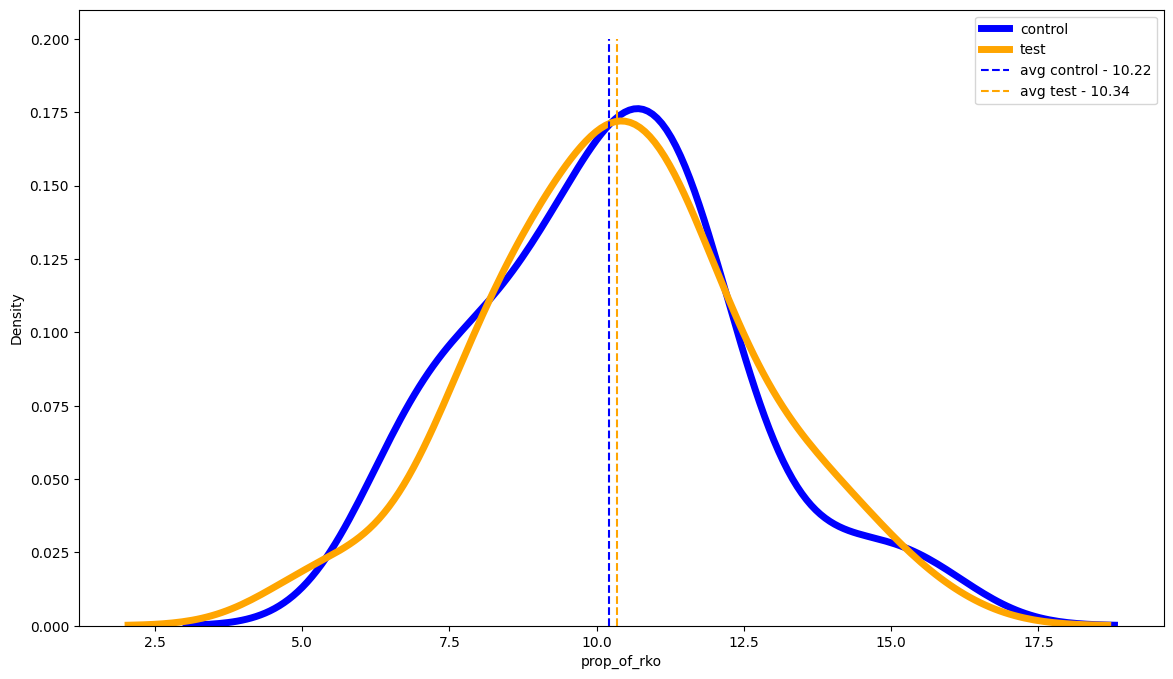

In [26]:
plt.figure(figsize=(14,8))
sns.distplot(control, hist=False, kde=True, 
             bins=int(10/5), color = 'blue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 5},
             label='control')
sns.distplot(test, hist=False, kde=True, 
             bins=int(10/5), color = 'orange', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 5},
             label='test')
plt.vlines(control_mean, ymax=0.2, ymin=0, linestyles='dashed', colors='blue', label=f'avg control - {control_mean:.2f}')
plt.vlines(test_mean, ymax=0.2, ymin=0, linestyles='dashed', colors = 'orange', label=f'avg test - {test_mean:.2f}')
plt.legend()
plt.show()

считаем стат значимость для конверсий в открытие

In [27]:
t_stat, p_value = sps.ttest_ind(df_test_rko, df_control_rko,alternative='greater') 
print('T-statistic value: ', t_stat)  
print('P-Value: ', p_value)
print('Alpha: 0.10')

print(np.percentile(control, 90))

print(np.mean(df_test_rko))
print(np.mean(df_control_rko))

T-statistic value:  0.25051329565090286
P-Value:  0.40141633813772093
Alpha: 0.10
12.297734627831716
10.338536585365853
10.215365853658536


считаем стат значимость для конверсий в утилизацию

In [28]:
t_stat, p_value = sps.ttest_ind(df_test_util, df_control_util, alternative='greater') 
print('T-statistic value: ', t_stat)  
print('P-Value: ', p_value)
print('Alpha: 0.10')

T-statistic value:  -0.6889813416299513
P-Value:  0.7535857913487002
Alpha: 0.10
